# Analysis of the dataset

In [441]:
import pymongo
import os

import string
import re
import textacy.preprocessing as tprep

import numpy as np
import pandas as pd

import fasttext
import spacy
from spacy.language import Language
from spacy import displacy

from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

## 1. Retrieving the data from the database

In [359]:
mg_host = os.environ.get("MONGO_HOST")
mg_username = os.environ.get("MONGO_USER")
mg_password = os.environ.get("MONGO_PW")
client = pymongo.MongoClient(f'mongodb://{mg_username}:{mg_password}@{mg_host}')

cvs = client.badtranslator.cvs

## 2. Creation and pre-processing of the dataframe

In [360]:
def mongo_to_pandas(db_coll, chunksize = 100, no_id=True):

    # Size of chunks
    skips_variable = range(0, db_coll.count_documents({}), int(chunksize))
    
    if len(skips_variable)<=1:
        skips_variable = [0,len(skips_variable)]

    for i in range(0, len(skips_variable)):
        
        if (skips_variable.stop - i * skips_variable.step < skips_variable.step):
            df_aux =pd.DataFrame(list(db_coll.find()[skips_variable[i]:skips_variable.stop+1]))
        else:                    
            df_aux =pd.DataFrame(list(db_coll.find()[skips_variable[i]:skips_variable[i+1]]))

        if no_id:
            del df_aux['_id']

        if 'df' not in locals():
            df =  df_aux
        else:
            df = pd.concat([df, df_aux], ignore_index=True)

    return df

In [361]:
df = mongo_to_pandas(cvs)

In [362]:
print(df.count())

email      812
cv        1541
status    1541
name       729
dtype: int64


Are there colums with null values beside 'email' and 'name'? **No**

In [363]:
for col in df.columns:
    print(col, df[col].isnull().sum())

email 729
cv 0
status 0
name 812


Language detection, because we only want resumes in English!

In [364]:
pretrained_model = "lid.176.bin" 
# Size: 129MB  , Download: https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
model = fasttext.load_model(pretrained_model)
langs = []

for item in df['cv']:
    item = item.replace("\n"," ")
    lang = model.predict(item)[0]
    langs.append(str(lang)[11:13])

df['lang'] = langs

In [365]:
df.loc[~df['lang'].isin(['en', 'ca', 'uk'])].sample(10)

,email,cv,status,name,lang
1361,NaN,Patricia Fierro Carrin \nPares de idiomas: \ni...,good,Patricia FierroM. Sc.,es
1457,NaN,cid:0cid:17cid:18cid:19cid:20cid:21cid:22cid:2...,good,ez-Ballina,ru
1229,NaN,M\nM\nA\nA\nR\nR\nA\nA\nA\nA\nG\nG\nU\nU\nI\nI...,good,LSGTranslations,es
1295,NaN,Lebenslauf auf Anfrage \nResume available upon...,good,Michael Ferris,de
1343,NaN,"NICOLA HOLMES \nTraducteur du franais, de lesp...",good,Nicola Holmes,fr
825,NaN,ADELEBLACK\nT R A D U C T O R A \nI N T R P R...,good,ele Black,es
1070,NaN,Informations personnelles : \nPrnom : \nNom de...,good,Helen Blair,fr
1151,NaN,Nombre:\nJos Manuel Pez Salinas\nFecha de Naci...,good,Jose Paez,es
1127,NaN,"JOEL PIA DIAZ \nMdico, miembro FACS \nTrabajo ...",good,Joel Pina Diaz,es
967,NaN,"David Tracey PhD, DipTrans IoL \nFreiberuflich...",good,TraceyPhD,de


*References*

@article{joulin2016bag,
  title={Bag of Tricks for Efficient Text Classification},
  author={Joulin, Armand and Grave, Edouard and Bojanowski, Piotr and Mikolov, Tomas},
  journal={arXiv preprint arXiv:1607.01759},
  year={2016}
}

We filter these records.

In [366]:
df_filtered = df.loc[df['lang'].isin(['en', 'ca', 'uk'])]

Shuffling of the dataset, because of the label bias of the original dataset.

In [367]:
df_filtered = df_filtered.sample(frac=1).reset_index(drop=True)

Removing the not needed columns

In [368]:
df_filtered.drop(["email"], axis=1, inplace=True)
df_filtered.drop(["name"], axis=1, inplace=True)
df_filtered.drop(["lang"], axis=1, inplace=True)

In [369]:
df_filtered.sample(5).T

,64,1239,1355,28,280
cv,mh \n Michael Hariton \n735 W183rd Street New ...,"LUIS J. QUIRINDONGO RODRGUEZ \nTranslator, Pro...",Robert Rutledge \nSpanish to English Translato...,"Lina Hamid \n78 Ali Moawad St., AlBarageel Roa...",CURRICULUM VITAE. \nExperienced English <> Kor...
status,good,good,good,bad,bad


## 3. Persistent copy of the dataframe

In [370]:
df_filtered.to_pickle("cvs_dataframe.pkl")

In [394]:
df_filtered = pd.read_pickle("cvs_dataframe.pkl")

## 4. Text normalization of column cv

### 4.1 Lowercasing of the cv column

In [395]:
df_filtered['cv'] = df_filtered['cv'].apply(lambda x: x.lower())

### 4.2 Contractions

Are there contractions. Check with "I'm".

In [396]:
contractions = df_filtered.loc[df['cv'].str.contains("I'm", case=False)]
print(contractions)

                                                     cv status
28    lina hamid \n78 ali moawad st., albarageel roa...    bad
127   eithne livesey \nfreelance translator \ntides ...   good
175   eliir lulucirruc \n eman\n sseaddn\nlmeme \n e...    bad
256   violeta n. lejtman \n 646 3395150 \nvioleta_le...   good
306   masaki ota \naddress: tokyo, japan \ndob: 1 oc...    bad
503   personal information: \nname: tina vigh \nnati...    bad
512   curriculam vitea \ngerman<> <>english<> transl...    bad
575   freelance translator, project manager \nand pr...    bad
650   michelle temple\nspanish/portuguese > english ...   good
660    curriculum vitie \npersonal info \n name: kar...    bad
728   cv \nsophie pasco \n2 rue de la mourette \n631...    bad
742      paul curlee gmez\n   education\nm.a. \n!\n2...   good
794   remington c. attig \nrcattig@gmail.com \n53584...   good
839   jane killy \nrussia, sofia \njanekilly@hotmail...    bad
865   denise doty \npersonal information: \n1850 qua...

Fixing contractions: We leave that to the Spacy pipeline for the time being

In [397]:
# import contractions
# df_filtered['cv'] = df_filtered['cv'].apply(lambda x: contractions.fix(x))

### 4.3 Special characters

Cleaning "pipeline"

In [398]:
def clean(text):
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r' {2,}', ' ', text) # We leave the line breaks for the time being
    return text.strip()

In [399]:
df_filtered['cv'] = df_filtered['cv'].apply(lambda x: clean(x))

### 4.4 Punctuation

Removing punctuation: Is this actually needed? 

In [400]:
# df['cv'] = df['cv'].apply(lambda x: ''.join([token for token in x if token not in string.punctuation]))

### 4.5 Textacy pipeline

Textacy pipeline.
We won't mask e-mail adresses and phone numbers, because they convey important information (fakes).

In [401]:
preproc = tprep.make_pipeline(
    tprep.normalize.hyphenated_words, # Removes hyphens at the end of lines
    tprep.normalize.whitespace, # Normalize and strip leading white spaces
    tprep.normalize.quotation_marks, # Normalizes quotation marks
    tprep.normalize.unicode, # Normalizes accented characters for subsequent removal
    tprep.remove.accents # Removes accents
)

In [402]:
df_filtered['cv'] = df_filtered['cv'].apply(lambda x: preproc(x))

## 5. Spacy pipeline preconfiguration

We remove the parser component from the pipeline, because it has problems dealing with the CR/LF of the converted pdfs.

In [403]:
nlp = spacy.load('en_core_web_md', exclude=["parser"])
nlp.enable_pipe("senter")

In [404]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x1cabfafaee0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x1cb2ce04100>),
 ('senter', <spacy.pipeline.senter.SentenceRecognizer at 0x1cadb667d00>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x1cb2a87f400>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x1cb2a22bb00>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x1cad15674a0>)]

## 6. Processing with Spacy

### 6.1 Removal of stop words

In [405]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [406]:
df_filtered['no_stopwords'] = df_filtered['cv'].apply(
    lambda x: " ".join([token.text for token in nlp.tokenizer(x) if not token.is_stop]))

### 6.2 Tokenization

In [425]:
df_filtered['tokens'] = df_filtered['no_stopwords'].apply(lambda x: [t.text for t in nlp.tokenizer(x) if ((len(t.text) > 2) & (t.text != '\n  '))])
# len = 2 is an arbitrary setting that leaves special characters and line breaks out

## 7. Analysis

### 7.1 Number of fake vs. legitimate resumes

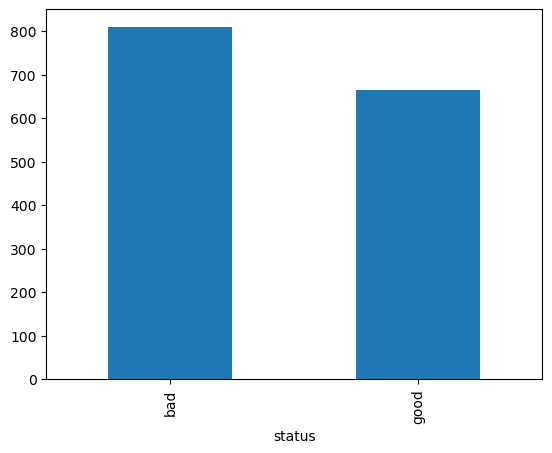

In [426]:
df_filtered.groupby(['status'])['cv'].count().plot(kind="bar")
plt.show()

### 7.2 Word cloud of legitimate resumes

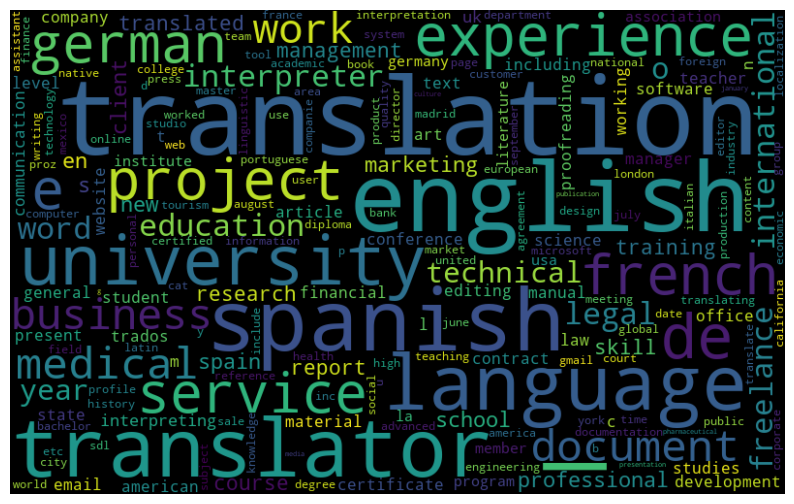

In [428]:
fake_cvs = df_filtered[df_filtered["status"] == "good"]
all_words = ' '.join([text for text in fake_cvs.no_stopwords])
wordcloud = WordCloud(width= 800, height= 500, max_font_size = 110, collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 7.3 Word cloud of the fake resumes

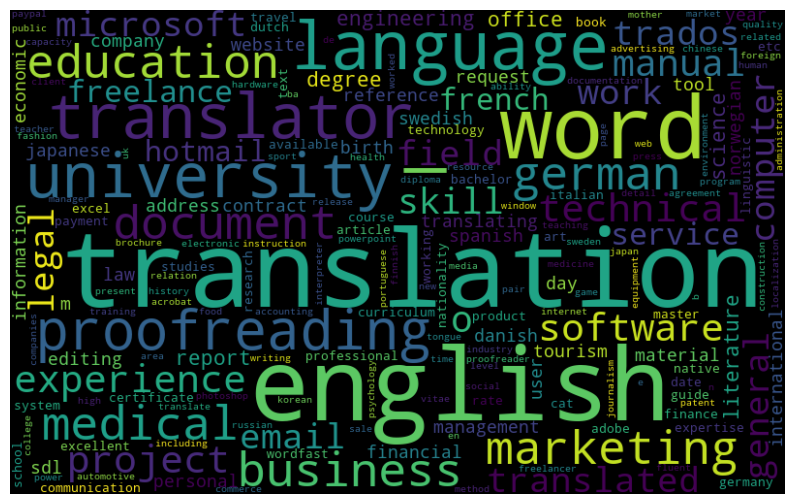

In [427]:
fake_cvs = df_filtered[df_filtered["status"] == "bad"]
all_words = ' '.join([text for text in fake_cvs.no_stopwords])
text_file = open("./all_words.txt", "w")
text_file.write(all_words)
text_file.close()
wordcloud = WordCloud(width= 800, height= 500, max_font_size = 110, collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 7.4 Word frequency

#### 7.4.1 Word frequency in legitimate CVs

In [437]:
from collections import Counter

In [436]:
tokens_good = [word for record in df_filtered[df_filtered["status"] == "good"]['tokens'].to_list() for word in record]

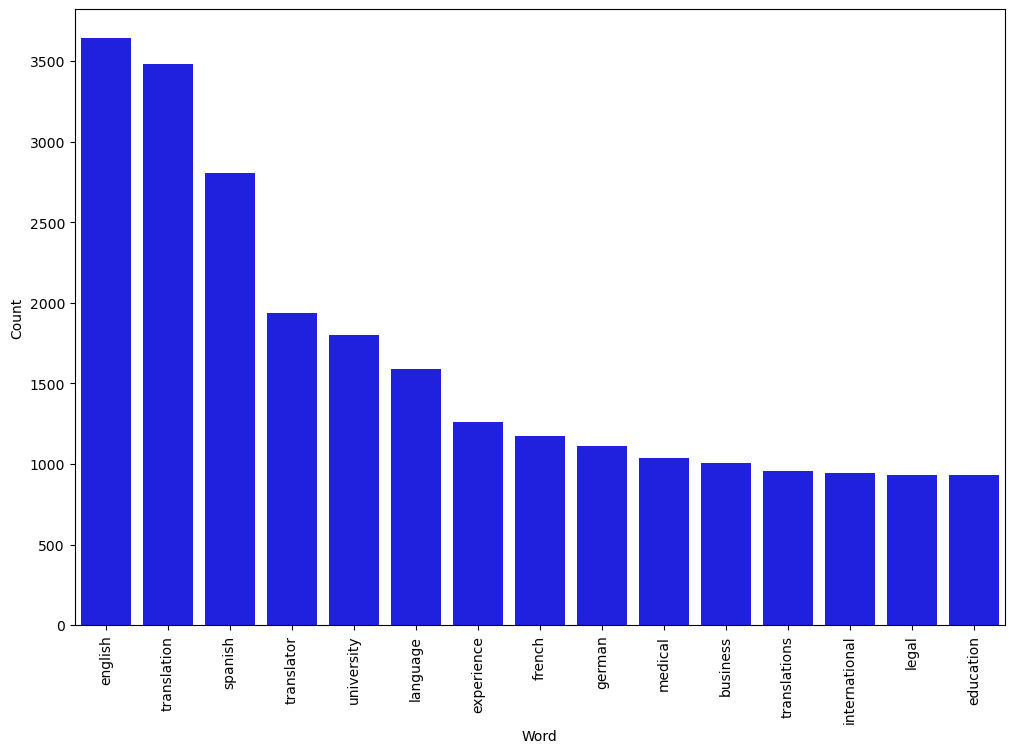

In [438]:
frequency_dict = Counter(tokens_good)

df_frequency = pd.DataFrame({"Word": list(frequency_dict.keys()),
                             "Frequency": list(frequency_dict.values())})

df_frequency = df_frequency.nlargest(columns = "Frequency", n = 15)

plt.figure(figsize=(12,8))
ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
ax.set(ylabel = "Count")
plt.xticks(rotation='vertical')
plt.show()

#### 7.4.2 Word frequency in fake CVs

In [439]:
tokens_bad = [word for record in df_filtered[df_filtered["status"] == "bad"]['tokens'].to_list() for word in record]

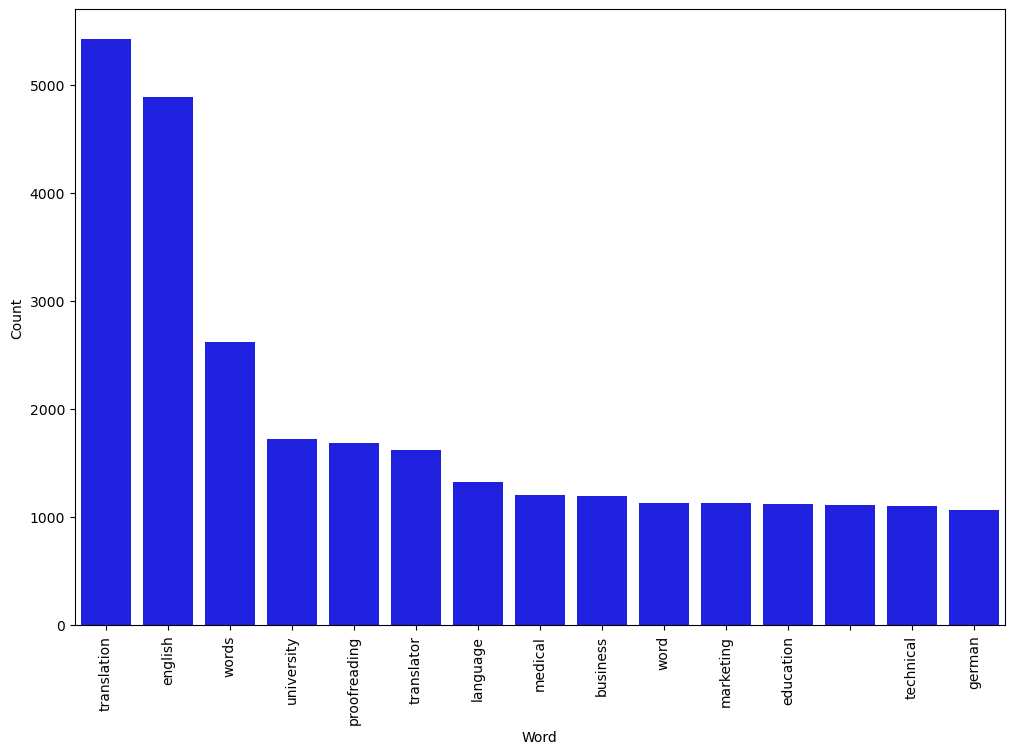

In [440]:
frequency_dict = Counter(tokens_bad)

df_frequency = pd.DataFrame({"Word": list(frequency_dict.keys()),
                             "Frequency": list(frequency_dict.values())})

df_frequency = df_frequency.nlargest(columns = "Frequency", n = 15)

plt.figure(figsize=(12,8))
ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
ax.set(ylabel = "Count")
plt.xticks(rotation='vertical')
plt.show()

## 8. Backup of the normalized dataframe

In [442]:
df_filtered.to_pickle("cvs_dataframe_normalized.pkl")